使用するモデルをDTからLightGBMに変更した

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

import collections

import lightgbm as lgb

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Duplicate key in file WindowsPath('C:/Users/GuestUser/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family:  IPAexGothic')


In [2]:
pd.set_option('display.max_rows', None)

データを変数に入れる

In [3]:
train = pd.read_table('train.tsv')
test = pd.read_csv('test.tsv',sep='\t')
sample = pd.read_csv('sample_submit.csv',header=None)

データを整える　※native-countryについて、trainかtest片方にしかないものは？に変換してしまう。

In [5]:
train = train.replace({"Y":{"<=50K" : 0, ">50K" : 1}})
train["Y"].value_counts()

0    12288
1     3992
Name: Y, dtype: int64

In [6]:
trainX = train.iloc[:,0:15]
y = train["Y"]
testX = test.copy()

In [7]:
train = train.drop(columns=["id","education"])
trainX = trainX.drop(columns=["id","education"])
testX = testX.drop(columns=["id","education"])

In [8]:
indexNum = testX[~testX["native-country"].isin(trainX["native-country"].unique())].index
for i in indexNum:
    testX.iat[i,12] = "?"
    print(testX.iat[i,12])

?


In [21]:
pd.reset_option('display.max_rows')

LightGBMでモデルを作成

In [22]:
trainX = pd.get_dummies(trainX)
testX = pd.get_dummies(testX)

In [23]:
model = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainX, y, test_size=0.3)

In [25]:
eval_set = [(X_test, y_test)]
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())
model.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)

[1]	valid_0's binary_logloss: 0.522598
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.492077
[3]	valid_0's binary_logloss: 0.467587
[4]	valid_0's binary_logloss: 0.447058
[5]	valid_0's binary_logloss: 0.43052
[6]	valid_0's binary_logloss: 0.415964
[7]	valid_0's binary_logloss: 0.403542
[8]	valid_0's binary_logloss: 0.392944
[9]	valid_0's binary_logloss: 0.38348
[10]	valid_0's binary_logloss: 0.375446
[11]	valid_0's binary_logloss: 0.368062
[12]	valid_0's binary_logloss: 0.361898
[13]	valid_0's binary_logloss: 0.356254
[14]	valid_0's binary_logloss: 0.351864
[15]	valid_0's binary_logloss: 0.347807
[16]	valid_0's binary_logloss: 0.343787
[17]	valid_0's binary_logloss: 0.340104
[18]	valid_0's binary_logloss: 0.336795
[19]	valid_0's binary_logloss: 0.333895
[20]	valid_0's binary_logloss: 0.331398
[21]	valid_0's binary_logloss: 0.327937
[22]	valid_0's binary_logloss: 0.325487
[23]	valid_0's binary_logloss: 0.323229
[24]	valid_0's binary_logloss:

LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [51]:
trainXpred = model.predict_proba(trainX)
trainXpred = trainXpred[:,1]
trainXl = len(trainXpred)
trainXpred = trainXpred.astype(object)
trainXpred

array([0.005831357148907298, 0.4087541489544169, 0.32721285961734015, ...,
       0.018187681946642213, 0.0006196388925261795, 0.18832829620060204],
      dtype=object)

In [64]:
ansRateList = pd.DataFrame()
for j in range(25):
    c = trainXpred.copy()
    n = (38+j)/100
    for i in range(trainXl):
        if c[i] <= n:
            c[i] = 0
        else:
            c[i] = 1
    ansRateBase = np.equal(c,y)
    ansRate = collections.Counter(ansRateBase)[True]/len(ansRateBase)
    ansRateData = pd.DataFrame([[n,ansRate]])
    ansRateList = pd.concat([ansRateList,ansRateData],ignore_index=True)
ansRateList

,0,1
0,0.38,0.870086
1,0.39,0.871069
2,0.40,0.873342
3,0.41,0.875184
4,0.42,0.875737
5,0.43,0.875614
6,0.44,0.876290
7,0.45,0.876966
8,0.46,0.876904
9,0.47,0.877457


([<matplotlib.axis.XTick at 0x28a867a4250>,
 [Text(0, 0, '0.38'),
  Text(1, 0, '0.39'),
  Text(2, 0, '0.4'),
  Text(3, 0, '0.41'),
  Text(4, 0, '0.42'),
  Text(5, 0, '0.43'),
  Text(6, 0, '0.44'),
  Text(7, 0, '0.45'),
  Text(8, 0, '0.46'),
  Text(9, 0, '0.47'),
  Text(10, 0, '0.48'),
  Text(11, 0, '0.49'),
  Text(12, 0, '0.5'),
  Text(13, 0, '0.51'),
  Text(14, 0, '0.52'),
  Text(15, 0, '0.53'),
  Text(16, 0, '0.54'),
  Text(17, 0, '0.55'),
  Text(18, 0, '0.56'),
  Text(19, 0, '0.57'),
  Text(20, 0, '0.58'),
  Text(21, 0, '0.59'),
  Text(22, 0, '0.6'),
  Text(23, 0, '0.61'),
  Text(24, 0, '0.62')])

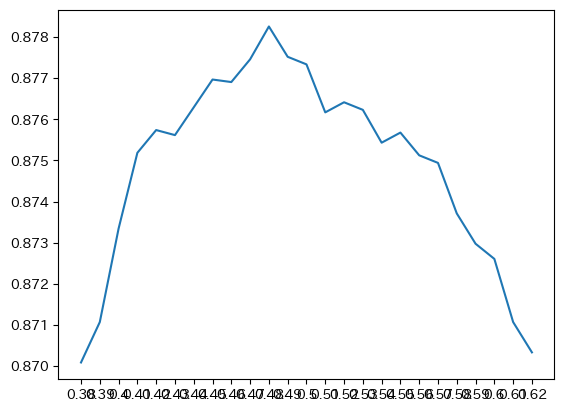

In [61]:
plt.plot(ansRateList[1])
plt.xticks(range(25),ansRateList[0])

予測に代入して結果を出力する

In [54]:
from sklearn import metrics
pred = model.predict_proba(testX)

In [55]:
pred = pred[:,1]
l = len(pred)

In [56]:
pred = pred.astype(object)
for i in range(l):
    if pred[i] <= 0.48:
        pred[i] = "<=50K"
    else:
        pred[i] = ">50K"

In [57]:
sample[1] = pred

In [58]:
sample.to_csv("submit2_5.csv",index=None,header=None)